# UCLA SETI group<br>Paul Pinchuk<br>Dechirping Efficiency

## Calculating *turbo*SETI Dechirping Efficiency

In the first part of this notebook, we provide the code to reproduce the analysis from Section 6.1 of [Margot et al. (2020)](https://arxiv.org/abs/2011.05265). Specifically, we will calculate the *dechirping efficiency* of the *turbo*SETI code. For a complete discussion, please refer to the cited work.

We will make use of several standard libraries for this task, namely
 - [os](https://docs.python.org/3/library/os.html)
 - [numpy](https://numpy.org/)
 - [pandas](https://pandas.pydata.org/)
 - [astropy](https://www.astropy.org/)
 - [logging](https://docs.python.org/3/library/logging.html) (required for compatibility with blimpy)
 - [matplotlib](https://matplotlib.org/) (only if you wish to visualize parts of the procedure)
 
We import these libraries below (with the exception of *astropy*, since we only need the `Angle` class). We will import `matplotlib` as needed.

In [2]:
import os
import numpy as np
import pandas as pd
from astropy.coordinates.angles import Angle
import logging

We will also need to import some relevant modules from the *blimpy* and *turbo*SETI packages. For more information on how to install these, please see the following GitHub repositories:
 - *blimpy* - https://github.com/UCBerkeleySETI/blimpy
 - *turbo*SETI ($\leq$ v1.3.0) - https://github.com/UCBerkeleySETI/turbo_seti/releases/tag/1.3.0

Version 1.3.0 of *turbo*SETI is likely the version used by [Price et al. (2020)](https://doi.org/10.3847/1538-3881/ab65f1) because it was released before any subsequent publication by the Breakthrough Listen (BL) team and it includes `DASK` parallelization, which is explicitly referred to in the cited work. In any case, it is the most up-to-date version of *turbo*SETI at the time of writing (September 7, 2020). 

We will use the `Waterfall` class as well as the `write_to_hdf5` and `hdf_reader` functions to write our data array in the correct format. We will then use the utilities from the `find_doppler` module of *turbo*SETI to recover the injected signals. Finally, we will use the `make_table` function to display the candidates found in the previous step.

In [2]:
from blimpy.io import write_to_hdf5, hdf_reader
from blimpy.waterfall import Waterfall
import turbo_seti.find_doppler.find_doppler as fd
from turbo_seti.find_event.find_event import make_table

The first thing we need to do is *monkey-patch* a function of the `find_doppler` module used to calculate the mean and standard deviation of the input spectra. Since we will be using noise-free data, we replace the relevant function (`comp_stats`) with one that always returns 0 for the mean and 1 for the standard deviation.

In [3]:
def always_return_zero_mean_unit_std(__):
    return 0, 1

In [4]:
fd.comp_stats = always_return_zero_mean_unit_std

Now we define some relevant parameters to the efficiency analysis.

In [5]:
n_rows_high_t_resolution = 816  # 16*51 - There are 51 time integrations, and the tree algorithm requires a power of 2 rows (16)
n_dfdts_injected = 420  # This is the number of unique drift rates (df/dt) that we will inject. We can calculate this using 4 Hz/s / 0.0096 Hz/s = 417, but we round up to 420
f_bins_between_signals = 1000  # This is the number of frequency bins between each injected signal. Must be large enough so that signals with large dfdts do not overlap
snr_injected = 1000  # The SNR of the injected signals. Must be large enough to capture any losses in sensitivity due to dechirping
fft_len = 2**20  # Length of the fft

The next cell defines a function to downsample high-time resolution data into low-time resolution data.

In [6]:
def integrate_in_time(data, t_int=51):
    n_rows, n_cols = data.shape
    n_new_rows = int(np.ceil(n_rows / t_int))
    new_data = np.zeros((n_new_rows, n_cols), dtype=np.float32)

    for start_ind in range(n_new_rows):
        data_to_average = data[start_ind*t_int:(start_ind+1)*t_int, :].copy()
        new_data[start_ind] = data_to_average.sum(axis=0)
    return new_data

The next cell creates a high-time resolution array of zeros (noise-free) and injects signals at all possible drift rates, spacing them apart by `f_bins_between_signals` frequency bins.

In [7]:
bl_data_with_sigs = np.zeros((n_rows_high_t_resolution, fft_len), dtype=np.float32)
n_rows = bl_data_with_sigs.shape[0]

for final_ind in range(n_dfdts_injected):
    split_inds = np.ceil(np.arange(final_ind + 2) / (final_ind + 1) * n_rows).astype(int)
    for roll_ind, (l_ind, r_ind) in enumerate(zip(split_inds[:-1], split_inds[1:])):
        bl_data_with_sigs[l_ind:r_ind, (final_ind+1)*f_bins_between_signals+roll_ind] = snr_injected / n_rows_high_t_resolution

# Downsample high-time resolution data containing signals
bl_data_with_sigs_int = integrate_in_time(bl_data_with_sigs)

Now we can take a look at some of these signals! Feel free to change `ind` to be any value in the range `[0, n_dfdts_injected)`. You may need to increase the `r_window` parameter for some of the larger drift rates.

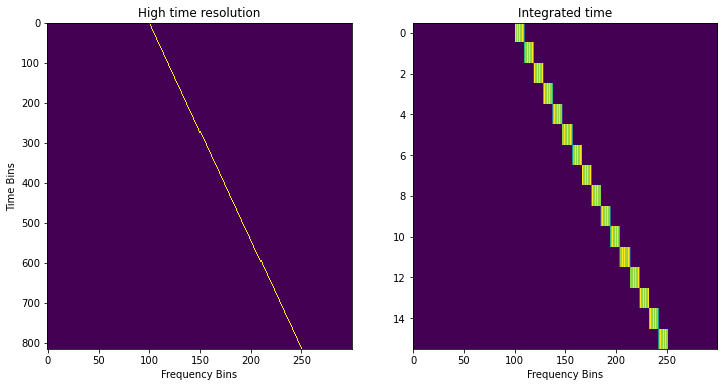

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

ind = 150
r_window = 200

_, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(bl_data_with_sigs[:, (ind+1)*f_bins_between_signals-100:(ind+1)*f_bins_between_signals + r_window], aspect='auto', interpolation="None")
axes[1].imshow(bl_data_with_sigs_int[:, (ind+1)*f_bins_between_signals-100:(ind+1)*f_bins_between_signals + r_window], aspect='auto', interpolation="None")
for ax in axes:
    ax.set_xlabel('Frequency Bins')
axes[0].set_ylabel('Time Bins')
axes[0].set_title('High time resolution')
axes[1].set_title('Integrated time')
plt.show()

Once we are satisfied with our injected signals, we can write them to a file for processing. The next cell defines a `header` dictionary with some dummy info about the observation.

In [9]:
header = {
    'DIMENSION_LABELS': np.array([b'frequency', b'feed_id', b'time']),
    'az_start': 0.0,
    'data_type': 1,
    'fch1': 0,
    'foff': 2.7939677238464355e-06,
    'machine_id': 0,
    'nbits': 32,
    'nchans': 1048576,
    'nifs': 1,
    'source_name': 'N/A',
    'src_dej': Angle('0d'),
    'src_raj': Angle('0h'),
    'telescope_id': 0,
    'tsamp': 18.253611008,
    'tstart': 0,
    'za_start': 0.0
}

Now we are ready to save the data! First, we create a `Waterfall` instance using the downsampled data. Then, we set some important class attributes, *monkey-patching* as needed. None of these attributes are important for the analysis we are performing, but they must be set in order for the code to function.

In [10]:
class container:
    def isheavy(self):
        return False
    
    
wf = Waterfall(data_array=bl_data_with_sigs_int.reshape(-1, 1, 2**20))
wf._update_header = lambda: None
wf.data = bl_data_with_sigs_int.reshape(-1, 1, 2**20)
wf.header = header
wf.logger = logging.getLogger()
wf.container = container()
wf.n_ints_in_file = 16

The next line writes the data to a file!

In [11]:
write_to_hdf5(wf, 'injected_dfdts.h5')

Now we are ready for the second step: Running *turbo*SETI. To do so, we first create a `FindDoppler` instance using the data we just saved. We set `min_drift` to be -0.0001 so that *turbo*SETI looks for the 0 Hz/s signal but doesn't bother with any other negative drift rates (since we only injected positive ones). We set `max_drift` to be 4 Hz/s and the `snr` threshold to 10 to emulate the parameters of [Price et al. (2020)](https://doi.org/10.3847/1538-3881/ab65f1).

In [20]:
doppler = fd.FindDoppler('injected_dfdts.h5',
                      min_drift = -0.0001,
                      max_drift = 4,
                      snr = 10,       
                      out_dir = './' # This is where the turboSETI output files will be stored. "./" is the current directory
                     )

We want the algorithm to write the candidate signals to a brand new file, so before we run it, we look for the file `injected_dfdts.dat` and remove it if it exists.

In [31]:
if os.path.exists('injected_dfdts.dat'):
    os.remove('injected_dfdts.dat')
assert(not os.path.exists('injected_dfdts.dat'))

And now we let *turbo*SETI run! Be patient - this may take 5-10 minutes.

In [32]:
doppler.search()

Now we are ready to take a look at the results. First, we will read in the file created by *turbo*SETI (`injected_dfdts.dat`), and we will add the injected drift rate values by observing the `ChanIndx` value (i.e. 0 Hz/s was injected at 1000, 0.009566 Hz/s at 2000, and so on).

In [33]:
df = make_table('injected_dfdts.dat')
dfdts = np.arange(n_rows_high_t_resolution) * ((header['foff'] * 1e6) ** 2) / n_rows_high_t_resolution
indxs = (np.arange(n_rows_high_t_resolution) + 1) * f_bins_between_signals
df['InjectedDFDT'] = [dfdts[np.argmin(np.abs(indxs - d))] for d in df.ChanIndx]
df[['InjectedDFDT', 'DriftRate', 'SNR', 'ChanIndx']]

,InjectedDFDT,DriftRate,SNR,ChanIndx
0,0.000000,0.000000,1000.000244,1000
1,0.009566,0.009566,1000.000244,2000
2,0.019133,0.019133,833.333534,3000
3,0.028699,0.028699,1000.000244,4000
4,0.038266,0.038266,799.019798,5000
...,...,...,...,...
1709,4.008359,3.817029,39.215687,420021
1710,4.008359,3.797896,39.215687,420022
1711,4.008359,3.817029,39.215687,420023
1712,4.008359,3.769197,39.215687,420024


If you wish, you can save the output to a separate csv file using the cell below.

In [34]:
df[['InjectedDFDT', 'DriftRate', 'SNR', 'ChanIndx']].to_csv('bl_injected_dfdts_recovered.csv', index=False)

Finally, we will reproduce the BL portion of Figure 7 from Margot et al. (2020). 

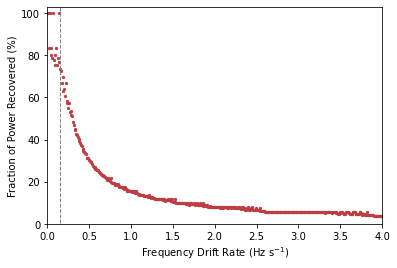

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# some DFDT values may have been detected at multiple other dfdt values. 
# Importantly, this only happens when the SNR ar multiple dfdt values is identical.
# To ensure that only one SNR value is recovered per injected DFDT, we use the '.SNR.unique()' function. 
# If multiple SNRs were detected for a given injected frequency, the code will fail later down the line.
pairs = list(df.groupby('InjectedDFDT').SNR.unique().items())

dfdts, snrs = list(zip(*pairs))
dfdts = np.array(dfdts)
snrs = np.array(snrs).flatten() / 10 

_ = plt.scatter(dfdts, snrs, marker='o', s=5, color='#bf3d42')
_ = plt.vlines(0.153, -100, 200, linestyle='--', color='gray', linewidth=1)  # Vertical line at 0.153 Hz/s (i.e. max drift rate without smearing)
_ = plt.xlabel('Frequency Drift Rate (Hz s$^{-1}$)')
_ = plt.ylabel('Fraction of Power Recovered (%)')
_ = plt.ylim(0, 103)
_ = plt.xlim(0, 4)

And that's it!

## Tree algorithm dechirping efficiency

[Margot et al. (2020)](https://arxiv.org/abs/2011.05265) explain that the tree algorithm is not perfect in that it reuses pre-computed sums to achieve `N log(N)` computational cost. As a result, the tree algorithm shifts every spectrum by an amount that is not always optimal. In other words, it is unable to perfectly dechirp most linear chirp waveforms. We can quantify the level of error associated with the use of the tree algorithm for a variety of array dimensions and reproduce Table 4 of [Margot et al. (2020)](https://arxiv.org/abs/2011.05265) as follows:

In [41]:
n_rows = [2**i for i in range(1, 13)]
n_cols = [50000 for r in n_rows]
shapes = list(zip(n_rows, n_cols))

results = {}
for s in shapes:
    print(f"Working on shape {s}")
    data_with_sigs = np.zeros(s, dtype=np.float32)
    n_rows = data_with_sigs.shape[0]
    for final_ind in range(n_rows): 
        split_inds = np.rint(np.arange(final_ind + 2) / (final_ind + 1) * n_rows).astype(int)
        for roll_ind, (l_ind, r_ind) in enumerate(zip(split_inds[:-1], split_inds[1:])):
            data_with_sigs[l_ind:r_ind, (final_ind+1)*10+roll_ind] = 1000 / n_rows
    
    # BL Tree Algorithm
    tree_findoppler = np.zeros(np.multiply(*data_with_sigs.shape), dtype=np.float64)
    nframes = tsteps = s[0]
    tdwidth = fftlen = s[1]
    _ = fd.populate_tree(data_with_sigs, tree_findoppler, nframes, tdwidth, tsteps, fftlen, shoulder_size=0, roll=0, reverse=0)
    fd.tt.taylor_flt(tree_findoppler, tsteps * tdwidth, tsteps)
    ibrev = np.array([fd.bitrev(i, int(np.log2(tsteps))) for i in range(tsteps)])
    f_by_fdot = tree_findoppler.reshape(s)[ibrev[np.arange(s[0])]]
    
    results[s[0]] = pd.DataFrame(
        [(dfdt_ind, f_by_fdot[dfdt_ind, (dfdt_ind+1)*10] / 10) for dfdt_ind in range(n_rows)],
        columns=['DFDT_bin', 'Percent']
    )

Working on shape (2, 50000)
Working on shape (4, 50000)
Working on shape (8, 50000)
Working on shape (16, 50000)
Working on shape (32, 50000)
Working on shape (64, 50000)
Working on shape (128, 50000)
Working on shape (256, 50000)
Working on shape (512, 50000)
Working on shape (1024, 50000)
Working on shape (2048, 50000)
Working on shape (4096, 50000)


We can print the output in Jupyter Markdown format:

In [62]:
print(f"|  Rows |  Min (%) |  Max (%) | Mean (%) |Median (%)|  STD (%) |")
print(f"|-------|----------|----------|----------|----------|----------|")
for pow2, res in results.items():
    stats = res.describe()['Percent']
    values = " | ".join([f'{pow2:6d}'] + list(map(lambda x: f'{x:8.2f}', stats.loc[['min', 'max', 'mean', '50%', 'std']].values)))
    print('|' + values + ' |')

|  Rows |  Min (%) |  Max (%) | Mean (%) |Median (%)|  STD (%) |
|-------|----------|----------|----------|----------|----------|
|     2 |   100.00 |   100.00 |   100.00 |   100.00 |     0.00 |
|     4 |   100.00 |   100.00 |   100.00 |   100.00 |     0.00 |
|     8 |    75.00 |   100.00 |    93.75 |   100.00 |    11.57 |
|    16 |    75.00 |   100.00 |    90.62 |    93.75 |    10.70 |
|    32 |    68.75 |   100.00 |    85.16 |    81.25 |    11.20 |
|    64 |    68.75 |   100.00 |    81.64 |    78.12 |     9.83 |
|   128 |    64.06 |   100.00 |    77.93 |    75.00 |     8.88 |
|   256 |    64.06 |   100.00 |    75.17 |    73.44 |     7.68 |
|   512 |    60.16 |   100.00 |    72.42 |    71.09 |     6.84 |
|  1024 |    60.16 |   100.00 |    70.08 |    69.14 |     6.10 |
|  2048 |    56.84 |   100.00 |    67.92 |    66.60 |     5.53 |
|  4096 |    56.84 |   100.00 |    66.01 |    64.94 |     5.06 |


If we copy the above output into a markdown cell, we can replicate Table 4 from [Margot et al. (2020)](https://arxiv.org/abs/2011.05265) in this notebook!

|  Rows |  Min (%) |  Max (%) | Mean (%) |Median (%)|  STD (%) |
|-------|----------|----------|----------|----------|----------|
|     2 |   100.00 |   100.00 |   100.00 |   100.00 |     0.00 |
|     4 |   100.00 |   100.00 |   100.00 |   100.00 |     0.00 |
|     8 |    75.00 |   100.00 |    93.75 |   100.00 |    11.57 |
|    16 |    75.00 |   100.00 |    90.62 |    93.75 |    10.70 |
|    32 |    68.75 |   100.00 |    85.16 |    81.25 |    11.20 |
|    64 |    68.75 |   100.00 |    81.64 |    78.12 |     9.83 |
|   128 |    64.06 |   100.00 |    77.93 |    75.00 |     8.88 |
|   256 |    64.06 |   100.00 |    75.17 |    73.44 |     7.68 |
|   512 |    60.16 |   100.00 |    72.42 |    71.09 |     6.84 |
|  1024 |    60.16 |   100.00 |    70.08 |    69.14 |     6.10 |
|  2048 |    56.84 |   100.00 |    67.92 |    66.60 |     5.53 |
|  4096 |    56.84 |   100.00 |    66.01 |    64.94 |     5.06 |